In [ ]:
import pandas as pd
import glob
import requests
import os

import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
%matplotlib inline
plt.style.use('fivethirtyeight')

# Import Data

In [2]:
def download_and_import_data(project_root_url: str, filename_prefix: str, part_numbers: list, local_folder: str = "dataset/") -> pd.DataFrame:
    """
    Downloads CSV files from a GitHub raw URL and concatenates them into a single DataFrame.

    Parameters:
        project_root_url (str): Base URL to the raw content of the repo (e.g., https://raw.githubusercontent.com/user/repo/branch/path/)
        filename_prefix (str): Prefix for the files to download (e.g., 'creditcard_part_')
        part_numbers (list): List of integer part numbers to download
        local_folder (str): Local folder to save files (default: 'dataset/')

    Returns:
        pd.DataFrame: Combined DataFrame from all parts
    """
    os.makedirs(local_folder, exist_ok=True)

    df_list = []

    for part in sorted(part_numbers):
        filename = f"{filename_prefix}{part}.csv"
        file_url = f"{project_root_url}{filename}"
        local_path = os.path.join(local_folder, filename)

        response = requests.get(file_url)
        if response.status_code == 200:
            with open(local_path, 'wb') as f:
                f.write(response.content)
            df_list.append(pd.read_csv(local_path))
            print(f"Downloaded and loaded: {filename}")
        else:
            print(f"Failed to download: {file_url} (status {response.status_code})")

    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        raise ValueError("No files were successfully downloaded.")


In [3]:
df = download_and_import_data(
    "https://raw.githubusercontent.com/angelomarcelino/credit-card-fraud-ml-project/e952d13ee3cb006cb901b263b43f904c8a8bd1a2/dataset/",
    "creditcard_part_",
    [1, 2, 3, 4]
)

Downloaded and loaded: creditcard_part_1.csv
Downloaded and loaded: creditcard_part_2.csv
Downloaded and loaded: creditcard_part_3.csv
Downloaded and loaded: creditcard_part_4.csv


In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Archicteture Class

In [6]:
from threading import local
import time

class Architecture(object):
    def __init__(self, model, loss_fn, optimizer, verbose = True):
        # Here we define the attributes of our class
        self.verbose = verbose

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        if self.verbose:
            print(f"Model sent to {self.device}")

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()
        if self.verbose:
            print("Architecture created")

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
            if self.verbose:
                print(f"Model sent to {device}")
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

        if self.verbose:
            # Print train loader info
            print("Loaders set")
            if self.train_loader.dataset:
                print(f"Train dataset size: {len(self.train_loader.dataset)}")
            if self.train_loader.batch_size:
                print(f"Train batch size: {self.train_loader.batch_size}")

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False, verbose_mini_batch=None, mini_batch_report = 100):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        local_verbose = verbose_mini_batch and self.verbose

        if local_verbose:
            print("\tStarting mini-batch...")

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        count = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            count += 1

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if local_verbose and count % mini_batch_report == 0:
                print(f"\t\tBatch {count}/{len(data_loader)}, loss: {mini_batch_loss}")

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        if self.verbose:
            print(f"Random seed set to {seed}")

    def train(self, n_epochs, seed=42, verbose=None, verbose_mini_batch=False, mini_batch_report=100, batch_report=10):
        self.set_seed(seed)

        local_verbose = self.verbose if verbose is None else verbose
        epoch_times = []

        if local_verbose:
            print("Starting training...")
            global_start = time.time()

        for epoch in range(n_epochs):
            epoch_start = time.time()
            self.total_epochs += 1

            # Training step
            loss = self._mini_batch(
                validation=False,
                verbose_mini_batch=verbose_mini_batch,
                mini_batch_report=mini_batch_report
            )
            self.losses.append(loss)

            # Validation step
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            epoch_end = time.time()
            elapsed = epoch_end - epoch_start
            epoch_times.append(elapsed)

            is_first_epoch = epoch == 0
            is_last_epoch = epoch == n_epochs - 1

            has_report = is_first_epoch or is_last_epoch or (epoch + 1) % batch_report == 0

            if local_verbose and has_report:
                # Predict remaining duration
                avg_time = sum(epoch_times) / len(epoch_times)
                remaining_epochs = n_epochs - (epoch + 1)
                estimated_remaining_secs = avg_time * remaining_epochs
                mins, secs = divmod(int(estimated_remaining_secs), 60)

                print(
                    f"Epoch {self.total_epochs}/{n_epochs} | "
                    f"Train loss: {loss:.8f} | Val. loss: {val_loss:.8f} | "
                    f"Time: {elapsed:.2f}s | ETA: {mins}m {secs}s"
                )

        if local_verbose:
            total_time = time.time() - global_start
            mean_epoch_time = sum(epoch_times) / len(epoch_times)
            print(f"Training completed in {total_time:.2f} seconds.")
            print(f"Mean time per epoch: {mean_epoch_time:.2f} seconds.")

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)
        if self.verbose:
            print(checkpoint)
            print(f"Checkpoint saved to {filename}")


    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

        if self.verbose:
            print(f"Checkpoint loaded from {filename}")
            print(checkpoint)

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

# Data Preparation

In [7]:
print(df.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed_num = 13

features = df.drop(columns='Class').values
labels = df['Class'].values

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=seed_num)

# Scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(227845, 30)
(56962, 30)
(227845,)
(56962,)


# Transform to tensor

In [10]:
import torch
import math

torch.manual_seed(seed_num)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
batch_size = 64

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size)

In [11]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_val_tensor.shape)
print(y_val_tensor.shape)

torch.Size([227845, 30])
torch.Size([227845, 1])
torch.Size([56962, 30])
torch.Size([56962, 1])


# Model Configuration

In [12]:
from torch import nn
import torch.optim as optim

# Sets learning rate
lr = 0.1

model = nn.Sequential()
model.add_module('linear', nn.Linear(x_train_tensor.shape[1], 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

# Training

In [13]:
arch = Architecture(model, loss_fn, optimizer)

arch.set_loaders(train_loader, val_loader)

Model sent to cuda
Architecture created
Loaders set
Train dataset size: 227845
Train batch size: 64


In [14]:
arch.load_checkpoint('model_checkpoint_1.pth')

Checkpoint loaded from model_checkpoint_1.pth
{'epoch': 100, 'model_state_dict': OrderedDict([('linear.weight', tensor([[-1.6927e-01,  3.0990e-01, -9.1759e-02,  2.2311e-02,  1.0133e+00,
          1.7492e-01, -1.1713e-01, -9.6299e-02, -1.7572e-01, -4.2951e-01,
         -9.0298e-01, -7.5746e-02,  1.1604e-01, -3.5262e-01, -5.2835e-01,
         -5.3134e-02, -9.1924e-02,  9.9794e-04, -3.1891e-02,  1.0342e-01,
         -3.5414e-01,  3.1134e-01,  3.7544e-01, -2.6410e-02,  1.4166e-01,
         -5.8434e-02,  8.4309e-03, -3.4518e-01, -8.4981e-02,  1.8341e-01]],
       device='cuda:0')), ('linear.bias', tensor([-8.6298], device='cuda:0'))]), 'optimizer_state_dict': {'state': {}, 'param_groups': [{'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]}, 'loss': [np.float64(0.021292415535931624), np.float64(0.005704477181717255), np.float64(0.004942420907448705), np.float64(0.0046

In [15]:
# n_epochs = 100
# arch.set_seed(seed_num)
# arch.train(n_epochs, seed=seed_num, verbose=True, verbose_mini_batch=False, batch_report=25)

In [16]:
# filename = 'model_checkpoint.pth'

# arch.save_checkpoint(filename)

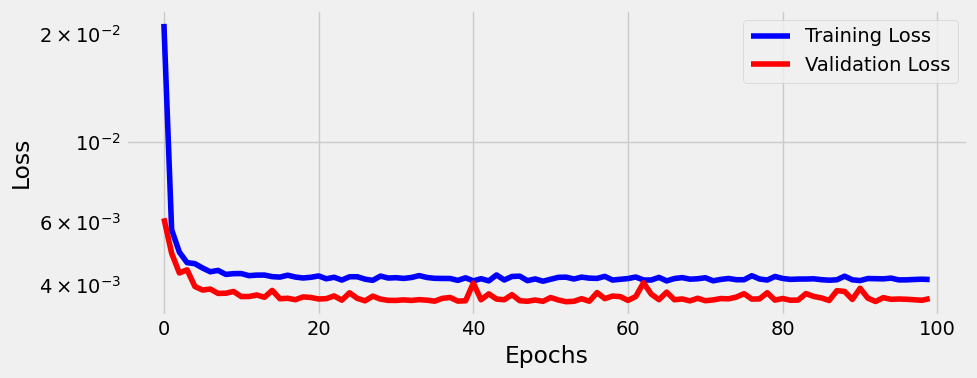

In [17]:
fig = arch.plot_losses()

In [18]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-1.6927e-01,  3.0990e-01, -9.1759e-02,  2.2311e-02,  1.0133e+00,
          1.7492e-01, -1.1713e-01, -9.6299e-02, -1.7572e-01, -4.2951e-01,
         -9.0298e-01, -7.5746e-02,  1.1604e-01, -3.5262e-01, -5.2835e-01,
         -5.3134e-02, -9.1924e-02,  9.9794e-04, -3.1891e-02,  1.0342e-01,
         -3.5414e-01,  3.1134e-01,  3.7544e-01, -2.6410e-02,  1.4166e-01,
         -5.8434e-02,  8.4309e-03, -3.4518e-01, -8.4981e-02,  1.8341e-01]],
       device='cuda:0')), ('linear.bias', tensor([-8.6298], device='cuda:0'))])


In [19]:
x_sample, y_sample = val_dataset[0]

x_sample

tensor([ 0.7610,  0.9075, -0.1591,  0.6072,  2.8437, -0.3138,  1.6204, -1.1022,
         0.4708,  0.7978,  0.8958, -2.5786,  0.7017,  1.4374, -1.7407, -2.7301,
         1.0282, -0.8356,  0.0920, -1.2278, -0.1510,  0.0837,  0.8617,  0.1580,
         0.1272, -0.3199,  0.1830,  0.2089, -0.0350, -0.2329])

In [20]:
y_sample

tensor([0.])

In [23]:
logits_val = arch.predict(x_sample)
logits_val

array([-6.005706], dtype=float32)

In [24]:
# prediction probabilities
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:4]).float())
prob_val

tensor([0.0025])

In [27]:
classes = (prob_val >= 0.5).to(torch.int8)
classes

tensor([0], dtype=torch.int8)

In [28]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [29]:
logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[56865,     7],
       [   39,    51]])

In [31]:
def split_cm(cm):
    # Actual negatives go in the top row,
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row,
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

In [35]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

In [36]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [39]:
precision_recall(cm_thresh50)


(np.float64(0.8793103448275862), np.float64(0.5666666666666667))

In [37]:
acc = accuracy_score(y_val, (probabilities_val >= 0.5))
acc

0.9991924440855307

In [38]:
tpr_fpr(cm_thresh50)

(np.float64(0.5666666666666667), np.float64(0.00012308341538894358))

In [40]:
def probability_line(ax, y, probs, threshold, shift=0.0, annot=False, colors=None):
    if colors is None:
        colors = ['r', 'b']
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    tn = (y == 0) & (probs < threshold)
    fn = (y == 0) & (probs >= threshold)
    tp = (y == 1) & (probs >= threshold)
    fp = (y == 1) & (probs < threshold)

    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    ax.scatter(probs[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probs[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)

    ax.scatter(probs[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probs[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'o(z) = P(y=1)')
    ax.set_title('Threshold = {}'.format(threshold))

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    return ax


In [41]:
def figure10(y, probabilities, threshold, shift, annot, colors=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    probability_line(ax, y, probabilities, threshold, shift, annot, colors)
    fig.tight_layout()
    return fig


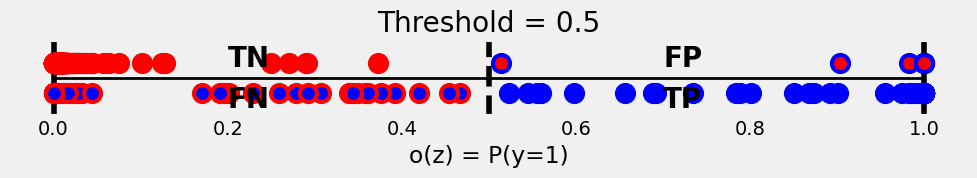

In [43]:
threshold = 0.5
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

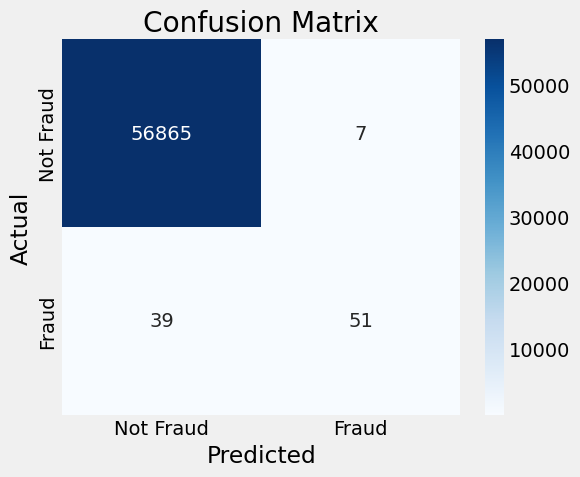

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['Not Fraud', 'Fraud']  # Adjust to match your actual classes

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm_thresh50, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# F1 score

In [48]:
def f1(cm):
    tn, fp, fn, tp = split_cm(cm)

    return (2 * tp) / ((2 * tp) + fp + fn)

In [49]:
f1(cm_thresh50)

np.float64(0.6891891891891891)